Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data


### Importing all the important libraries

In [10]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns

In [11]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## we will create train dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## we will create Validation dataset here
## Uisng seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure we resize images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [18]:
# DELETE OUTPUT FOLDER created in previous run when creating data
#path_to_train="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
#import shutil
#for i in class_names:
    #p = path_to_train + i+"/output"
    #print(p)
    #try:
      #shutil.rmtree(p)
    #except OSError as e:
       #print("Error: %s : %s" % (path_to_train, e.strerror))

### Visualize the data
####  code to visualize one instance of all the nine classes present in the dataset

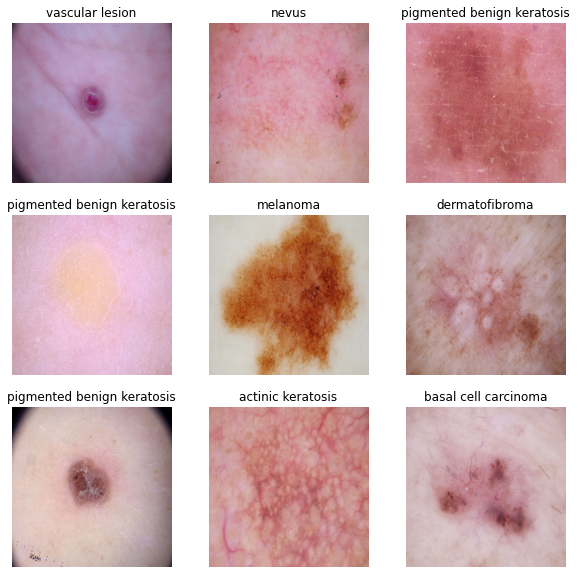

In [19]:
import matplotlib.pyplot as plt

### We will use Train dataset to Visualize the data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
# We will Rescalevalues using normalization layer
#layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [22]:
# We will use "Adam" as our optimizer
# and Cross entropy as Loss function.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

### Train the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 93ms/step - loss: 2.3895 - accuracy: 0.2083 - val_loss: 2.0141 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8588 - accuracy: 0.3224 - val_loss: 1.5998 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4807 - accuracy: 0.4784 - val_loss: 1.4170 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3296 - accuracy: 0.5461 - val_loss: 1.4534 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3506 - accuracy: 0.5261 - val_loss: 1.6072 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2352 - accuracy: 0.5631 - val_loss: 1.4025 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1632 - accuracy: 0.5915 - val_loss: 1.4714 - val_accuracy: 0.5280
Epoch 8/20
5

### Visualizing training results

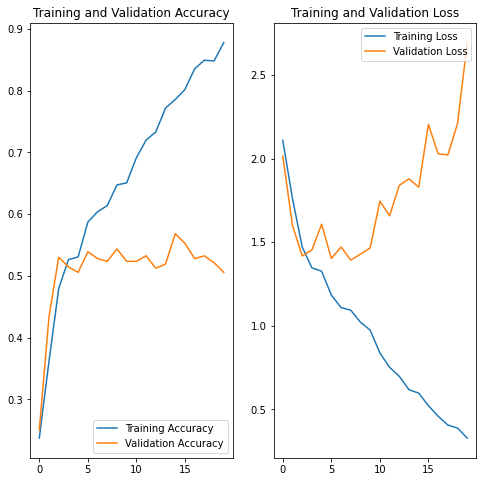

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Observations** -


*   Training accuracy is increasing over time, whereas validation accuracy is not increasing.


*   Also training Loss is decreasing over time but Validaton loss is increasing.


*   This means our model is **Overfitting**.

*    It means that our model will have a difficulty generalizing on a new dataset.


**Methods to remove overfitting** -


*   We will use Data **Augmentation** and
*   **dropouts** (randomly drops out a number of output units from the layer) during the training process to avoid overfitting.




In [26]:
# After Analyzing the model fit history for presence of  overfit, we will choose an appropriate data augumentation strategy. 
# We will use horizontal flip,Random rotation and Random Zoom for augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

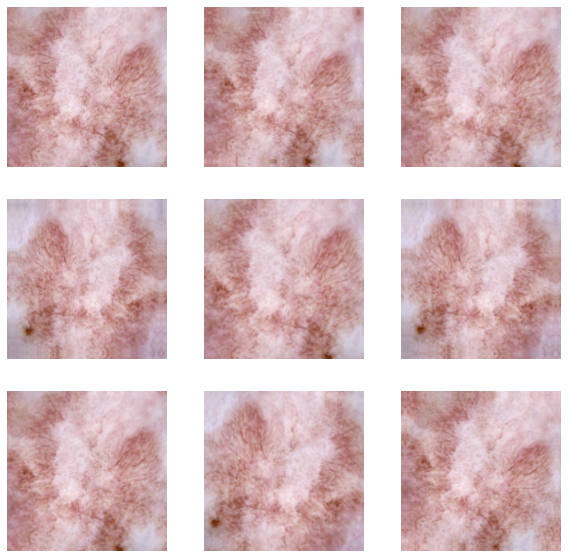

In [27]:
# Visualizing how augmentation strategy works for one instance of training image.


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model using dropout and data augmentation


In [28]:
## Using DropOut layer to reduce Overfitting
## We will use drop out with 20% i.e 0.2 value

#Model Building

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
   layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
   layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")
])

### Compiling the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)       

### Training the model

In [31]:
#training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 30ms/step - loss: 3.7543 - accuracy: 0.1816 - val_loss: 2.0659 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 2.0196 - accuracy: 0.2442 - val_loss: 1.9210 - val_accuracy: 0.2931
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.8159 - accuracy: 0.3466 - val_loss: 1.6718 - val_accuracy: 0.3848
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6394 - accuracy: 0.4124 - val_loss: 1.6752 - val_accuracy: 0.4116
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4903 - accuracy: 0.4771 - val_loss: 1.5415 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4727 - accuracy: 0.4761 - val_loss: 1.5366 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3876 - accuracy: 0.5128 - val_loss: 1.5209 - val_accuracy: 0.4855
Epoch 8/20
56

### Visualizing the results

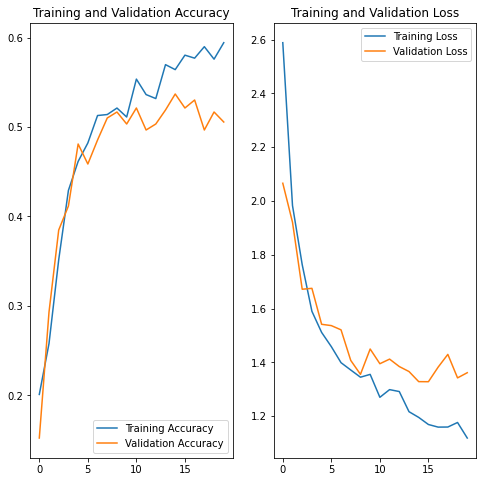

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations :**



*   We can see that adding DropOuts and Augmentation has significant increase on performance on Validation dataset.


*   We can see as Training accuracy is increasing Validation Accuracy is also increasing and now model less overfitting as compare to previous model.

*   both training and validation set have approximately same accuracy





#### **Distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
##Check no of images for each Class

import os
from pathlib import Path
originaldict={}
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
          name= str(path.name)
          count=(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
          per= (count*100/image_count_train)
          print("{:<20s}:   {} or {:.2f}%".format(name, count, per))
            #print("There are " + str(len([name for name in os.listdir(path) \
            #if os.path.isfile(os.path.join(path, name))])) + " images for class : " + \
            #str(path.name))
            
print("Distribution of classes : ")
count_files(data_dir_train)

Distribution of classes : 
actinic keratosis   :   114 or 5.09%
basal cell carcinoma:   376 or 16.79%
dermatofibroma      :   95 or 4.24%
melanoma            :   438 or 19.56%
nevus               :   357 or 15.94%
pigmented benign keratosis:   462 or 20.63%
seborrheic keratosis:   77 or 3.44%
squamous cell carcinoma:   181 or 8.08%
vascular lesion     :   139 or 6.21%


#### **Findings:** 
#### -  Class: **seborrheic keratosis** has least number of samples(77)
#### -  Class: **pigmented benign keratosis**  dominate the data in terms proportionate number of samples.(462)


#### **Rectify the class imbalance** 
#### **Context:** We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE0E0ADC978>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E0B93630>: 100%|██████████| 500/500 [00:19<00:00, 25.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E047B3C8>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE0E0B93A58>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE0E0ADDDD8>: 100%|██████████| 500/500 [00:19<00:00, 25.20 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE073694908>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FE0E05DCC50>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E0AE3208>: 100%|██████████| 500/500 [00:19<00:00, 25.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE0E04A4E10>: 100%|██████████| 500/500 [00:43<00:00, 11.59 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE07343C908>: 100%|██████████| 500/500 [00:19<00:00, 25.56 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0E05B2BA8>:   0%|          | 1/500 [00:00<01:20,  6.23 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE0731D3F28>: 100%|██████████| 500/500 [00:20<00:00, 24.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
#creating original df without images inside output folder

from glob import glob
#path of images inside subfolders with class name
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list_original[:5])
#labels of folder
lesion_list_original = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(lesion_list_original[:5])

#creating Dict using path and labels
dataframe_dict_original= dict(zip(path_list_original, lesion_list_original))

#creating dataframe from above dictionary
original_df= pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

['/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028076.jpg', '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027452.jpg', '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026857.jpg', '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027562.jpg', '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026626.jpg']
['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis']


,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Skin ca...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Skin ca...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Skin ca...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Skin ca...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Skin ca...,actinic keratosis


In [38]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_31c3028c-e468-4b36-a068-35d17d401543.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_4efc6642-eb44-41a8-8346-e57d534bb322.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_b22a7ae1-3ed0-4a5f-a6a2-efa68f979218.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_4e9c8436-3100-4c85-85ce-1f5b051f4474.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.shape


(4500, 2)

In [42]:
#Appending new dataframe of outpt images to  original df
new_df = original_df.append(df2)
new_df.shape

(6739, 2)

In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Training the model on the data created using Augmentor**: 

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Create a training dataset:** 

In [45]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Create a validation dataset:** 

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Create model (with normalization and newly created data):** 

In [47]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")
])


#### **Compile model:** 

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Train model:**  

In [49]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 228ms/step - loss: 2.7554 - accuracy: 0.1475 - val_loss: 1.6869 - val_accuracy: 0.3697
Epoch 2/30
169/169 [==============================] - 39s 226ms/step - loss: 1.6118 - accuracy: 0.3958 - val_loss: 1.3817 - val_accuracy: 0.4677
Epoch 3/30
169/169 [==============================] - 39s 225ms/step - loss: 1.3602 - accuracy: 0.4997 - val_loss: 1.2644 - val_accuracy: 0.5204
Epoch 4/30
169/169 [==============================] - 40s 232ms/step - loss: 1.2376 - accuracy: 0.5423 - val_loss: 1.2323 - val_accuracy: 0.5724
Epoch 5/30
169/169 [==============================] - 38s 219ms/step - loss: 1.0633 - accuracy: 0.6154 - val_loss: 1.1152 - val_accuracy: 0.5798
Epoch 6/30
169/169 [==============================] - 38s 218ms/step - loss: 0.8962 - accuracy: 0.6684 - val_loss: 0.9194 - val_accuracy: 0.6615
Epoch 7/30
169/169 [==============================] - 38s 219ms/step - loss: 0.8094 - accuracy: 0.7089 - val_loss: 0.9872 - val_ac

#### **Todo:**  Visualize the model results

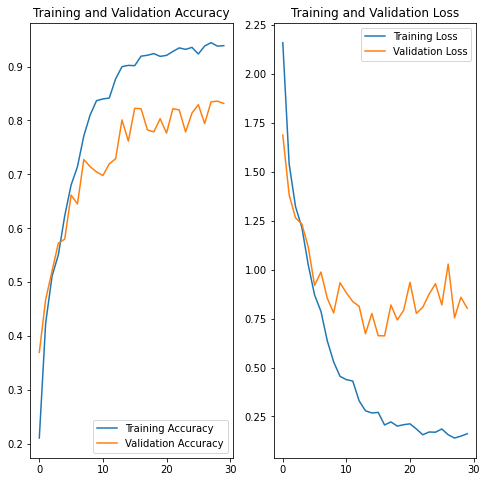

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Observations:**  


*   We can see that class rebalancing techinques certainly helps in reducing overfitting of model.


*   Also after using dropouts overfitting is getting reduced as compare to previous model



